# Git Storage Model - in details (breakdown)

## Description
https://wiki/display/gqd/Git+Storage

gas_storage5

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os, sys
path = os.getcwd()
while not path.endswith('research'):    
    path = os.path.abspath(os.path.join(path, '../'))
sys.path.append(path)

In [3]:
import os, sys
import pandas as pd
import numpy as np
from datetime import datetime, date

In [4]:
#a number of utilities:
from gmt.fom.gas.shared.utils.common import pa
from gmt.fom.gas.shared.utils.dframe import ddff
from gmt.fom.gas.shared.utils.common import flatten_lst

In [5]:
from gmt.fom.gas.shared.models.git_storage.model import GitStorageModel

In [6]:
import cmdty_storage

In [7]:
import logging

In [8]:
logger = logging.getLogger()

In [9]:
logger.setLevel(logging.INFO)

# Market

so for UK, prices are in pence per therm
which i think we need to conver to pence per kwh 

and then I need to convert stroage capacity into Kwh

from kwh to therms you divide by by 29.3071
from therms to kwh you multiply by 29.3071

## IR

In [10]:
from gmt.fom.gas.shared.models.git_storage.data.ir import Ir

In [11]:
ir = Ir(ccy='GBP')

2021-06-11 11:40:32,137: C:\git\gmt-fom-gas-research\gmt\fom\gas\shared\models\git_storage\data\ir.py: 21: INFO: Getting IR curve data....
2021-06-11 11:40:33,783: C:\git\gmt-fom-gas-research\gmt\fom\gas\shared\models\git_storage\data\ir.py: 26: INFO: Format ir curve ....


<AxesSubplot:xlabel='date'>

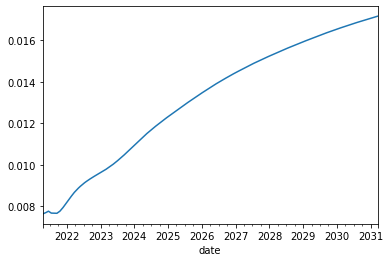

In [12]:
ir.curve.plot()

## Forward

In [13]:
from gmt.fom.gas.shared.models.git_storage.data.fwd import Forward

In [14]:
forward = Forward(ccy=ir.ccy, smooth_curve=True, apply_weekend_shaping=True, weekend_shaping_factor=0.999)

2021-06-11 11:40:36,763: C:\git\gmt-fom-gas-research\gmt\fom\gas\shared\models\git_storage\data\fwd.py: 40: INFO: Getting forward curve data....
2021-06-11 11:40:37,345: C:\git\gmt-fom-gas-research\gmt\fom\gas\shared\models\git_storage\data\fwd.py: 46: INFO: Format forward curve....


In [15]:
forward.params

{'smooth_curve': True,
 'apply_weekend_shaping': True,
 'weekend_shaping_factor': 0.999,
 'ccy': 'GBP'}

<AxesSubplot:>

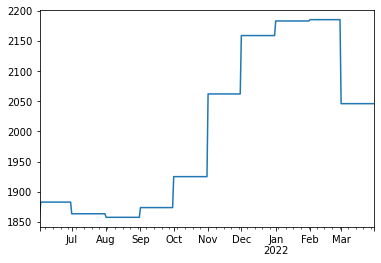

In [16]:
forward.curve.plot()

# Diffusion

In [17]:
from gmt.fom.gas.shared.models.git_storage.diffusion import Diffusion

In [18]:
diffusion = Diffusion(
                        spot_mean_reversion=30.0,
                        spot_vol=0.51,
                        long_term_vol=0.31,
                        seasonal_vol=0.2)

In [19]:
diffusion.params

{'spot_mean_reversion': 30.0,
 'spot_vol': 0.51,
 'long_term_vol': 0.31,
 'seasonal_vol': 0.2}

# Calibrator

In [20]:
from gmt.fom.gas.shared.models.git_storage.calibrator import Calibrator

In [21]:
calibrator = Calibrator(
                        num_sims=4000,
                        basis_funcs= '1 + x_st + x_sw + x_lt + s + x_st**2 + x_sw**2 + x_lt**2 + s**2 + s * x_st',
                        seed=11,
                        seed_is_random=False,
                        fwd_sim_seed=13,
                        set_fwd_sim_seed=True,
                        extra_decisions=0,
                        num_inventory_grid_points=100,
                        numerical_tolerance=1e-10)

In [22]:
calibrator.params

{'num_sims': 4000,
 'basis_funcs': '1 + x_st + x_sw + x_lt + s + x_st**2 + x_sw**2 + x_lt**2 + s**2 + s * x_st',
 'seed': 11,
 'seed_is_random': False,
 'fwd_sim_seed': 13,
 'set_fwd_sim_seed': True,
 'extra_decisions': 0,
 'num_inventory_grid_points': 100,
 'numerical_tolerance': 1e-10,
 'settlement_rule': <function gmt.fom.gas.shared.models.git_storage.calibrator.settlement_rule(delivery_date)>}

# Storage

In [23]:
from gmt.fom.gas.shared.models.git_storage.storage import Storage

In [40]:
str_type = 'SIMPLE'

if str_type == 'SIMPLE':
    storage = Storage('SIMPLE', 
                  freq='D',
                  storage_start='2021-06-02',
                  storage_end='2022-03-31',
                  injection_cost=0.692359398,
                  withdrawal_cost=0.202930711,
                  min_inventory=0.0,
                  max_inventory=4.387e+9,
                  max_injection_rate=1.82e+8,
                  max_withdrawal_rate=1.82e+8,
                  terminal_storage_npv=None #<--- MustBeEmptyAtEnd is True
                     )
else:
    storage = Storage('RATCHETS', 
                  freq='D',
                  storage_start='2021-06-02',
                  storage_end='2022-03-31',
                  injection_cost=0.01,
                  withdrawal_cost=0.025)

# Putting all together Model

In [26]:
from gmt.fom.gas.shared.models.git_storage.model import GitStorageModel

In [27]:
from gmt.fom.gas.shared.models.git_storage.model import *

In [28]:
myModel = GitStorageModel(
                          val_date='2021-06-02',
                          inventory=1500.0,
                          
                          
                          
                          ir = ir,
                          forward=forward,
                          
                          diffusion=diffusion,
                          calibrator=calibrator,
                            
                          storage=storage, 
                          )

In [29]:
myModel.fit()

2021-06-11 11:41:31,660: C:\git\gmt-fom-gas-research\gmt\fom\gas\shared\models\git_storage\model.py: 92: INFO: Fitting....
2021-06-11 11:41:32,110: cmdty.storage.multi-factor: 401: INFO: Compiling basis functions. Takes a few seconds on the first run..
2021-06-11 11:41:40,886: cmdty.storage.multi-factor: 403: INFO: Compilation of basis functions complete..
2021-06-11 11:41:40,888: cmdty.storage.multi-factor: 406: INFO: Calculating intrinsic value..
2021-06-11 11:41:41,409: cmdty.storage.multi-factor: 416: INFO: Calculation of intrinsic value complete..
2021-06-11 11:41:41,410: cmdty.storage.multi-factor: 419: INFO: Calculating LSMC value..
2021-06-11 11:41:41,516: cmdty.storage.multi-factor: 325: INFO: Starting regression spot price simulation..
2021-06-11 11:41:41,910: cmdty.storage.multi-factor: 325: INFO: Spot regression price simulation complete..
2021-06-11 11:41:41,922: cmdty.storage.multi-factor: 325: INFO: Starting backward induction..
2021-06-11 11:42:06,643: cmdty.storage.mul

Full Value=7,877,113.3251
Intrinsic Value=5,026,489.0998
Extrinsic Value=2,850,624.2254


In [30]:
myModel.results.expected_profile

inventory  inject_withdraw_volume  cmdty_consumed  \
2021-06-02  1500.000000              193.750000             0.0   
2021-06-03  1693.750000               82.060859             0.0   
2021-06-04  1775.810859               65.214937             0.0   
2021-06-05  1841.025796               54.317412             0.0   
2021-06-06  1895.343208               41.474991             0.0   
...                 ...                     ...             ...   
2022-03-27   379.230837              -93.988286             0.0   
2022-03-28   285.242551              -94.479481             0.0   
2022-03-29   190.763070              -91.835074             0.0   
2022-03-30    98.927996              -98.927996             0.0   
2022-03-31     0.000000                0.000000             0.0   

            inventory_loss  net_volume      period_pv  
2021-06-02             0.0 -193.750000 -359923.188689  
2021-06-03             0.0  -82.060859 -148044.933693  
2021-06-04             0.0  -65.214937 -113787.204901  
2021-06-05             0.0  -54.317412  -91870.302398  
2021-06-06             0.0  -41.474991  -65963.017886  
...                    ...         ...            ...  
2022-03-27             0.0   93.988286  185102.686095  
2022-03-28             0.0   94.479481  184895.733902  
2022-03-29             0.0   91.835074  176203.541262  
2022-03-30             0.0   98.927996  196735.144788  
2022-03-31             0.0    0.000000       0.000000  

[303 rows x 6 columns]

In [31]:
ddff(myModel.results.combined)

inject_withdraw_volume         ext          fwd   run_date
2021-06-02              193.750000  193.750000  1859.535495 2021-06-02
2021-06-03                0.000000   82.060859  1882.981175 2021-06-02
2021-06-04                0.000000   65.214937  1882.981175 2021-06-02
2021-06-05                0.000000   54.317412  1882.981175 2021-06-02
2021-06-06                0.000000   41.474991  1882.981175 2021-06-02
2021-06-07                0.000000   42.512134  1882.981175 2021-06-02
2021-06-08                0.000000   46.439785  1882.981175 2021-06-02
2021-06-09                0.000000   39.540470  1882.981175 2021-06-02
2021-06-10                0.000000   39.078294  1882.981175 2021-06-02
2021-06-11                0.000000   37.148420  1882.981175 2021-06-02
2021-06-12                0.000000   34.215257  1882.981175 2021-06-02
2021-06-13                0.000000   36.053555  1882.981175 2021-06-02
2021-06-14                0.000000   34.578100  1882.981175 2021-06-02
2021-06-15                0.000000   35.480390  1882.981175 2021-06-02
2021-06-16                0.000000   37.629144  1882.981175 2021-06-02
2021-06-17                0.000000   35.319395  1882.981175 2021-06-02
2021-06-18                0.000000   32.237118  1882.981175 2021-06-02
2021-06-19             -192.343750   33.325911  1882.981175 2021-06-02
2021-06-20             -187.535156   34.036318  1882.981175 2021-06-02
2021-06-21             -182.846777   32.272188  1882.981175 2021-06-02
2021-06-22                0.000000   28.127675  1882.981175 2021-06-02
2021-06-23             -178.275608   23.724520  1882.981175 2021-06-02
2021-06-24             -173.818718   27.444174  1882.981175 2021-06-02
2021-06-25             -169.473250   22.171134  1882.981175 2021-06-02
2021-06-26             -165.236419   19.299275  1882.981175 2021-06-02
2021-06-27             -161.105508   16.816399  1882.981175 2021-06-02
2021-06-28             -157.077870   15.070584  1882.981175 2021-06-02
2021-06-29                0.000000   11.415642  1882.981175 2021-06-02
2021-06-30             -126.036944    5.603056  1882.981175 2021-06-02
2021-07-01              250.000000   61.460647  1863.638489 2021-06-02
2021-07-02              240.625000   54.000515  1863.638489 2021-06-02
2021-07-03              231.601562   49.124056  1863.638489 2021-06-02
2021-07-04                0.000000   45.729388  1863.638489 2021-06-02
2021-07-05                0.000000   48.441896  1863.638489 2021-06-02
2021-07-06                0.000000   43.636743  1863.638489 2021-06-02
2021-07-07              222.916504   37.367879  1863.638489 2021-06-02
2021-07-08              214.557135   32.031741  1863.638489 2021-06-02
2021-07-09              206.511242   29.292743  1863.638489 2021-06-02
2021-07-10              198.767071   27.084215  1863.638489 2021-06-02
2021-07-11              191.313306   24.294108  1863.638489 2021-06-02
2021-07-12              184.139057   26.997489  1863.638489 2021-06-02
2021-07-13              177.233842   26.926769  1863.638489 2021-06-02
2021-07-14                0.000000   20.548062  1863.638489 2021-06-02
2021-07-15                0.000000   21.962684  1863.638489 2021-06-02
2021-07-16                0.000000   18.165200  1863.638489 2021-06-02
2021-07-17                0.000000   20.295334  1863.638489 2021-06-02
2021-07-18                0.000000   19.659256  1863.638489 2021-06-02
2021-07-19                0.000000   21.201747  1863.638489 2021-06-02
2021-07-20                0.000000   17.156703  1863.638489 2021-06-02
2021-07-21                0.000000   15.519857  1863.638489 2021-06-02
2021-07-22                0.000000   11.682455  1863.638489 2021-06-02
2021-07-23                0.000000   10.331547  1863.638489 2021-06-02
2021-07-24                0.000000   11.319265  1863.638489 2021-06-02
2021-07-25                0.000000    9.313983  1863.638489 2021-06-02
2021-07-26                0.000000    7.263667  1863.638489 2021-06-02
2021-07-27                0.000000  

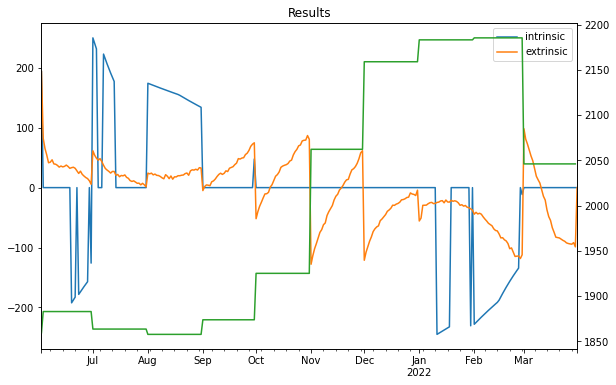

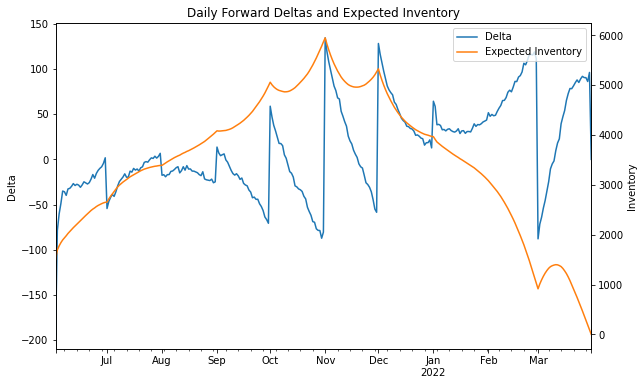

In [32]:
myModel.plot(batch_mode=False)

In [33]:
myModel.save_results()

In [34]:
myModel.email_results()

# Retrieve job results

In [35]:
myModel.data_adapter.results_t_range

[datetime.date(2021, 6, 2),
 datetime.date(2021, 6, 7),
 datetime.date(2021, 6, 8),
 datetime.date(2021, 6, 9),
 datetime.date(2021, 6, 11)]

In [36]:
t_range = myModel.data_adapter.results_t_range; t_range

[datetime.date(2021, 6, 2),
 datetime.date(2021, 6, 7),
 datetime.date(2021, 6, 8),
 datetime.date(2021, 6, 9),
 datetime.date(2021, 6, 11)]

In [37]:
myModel.data_adapter.retrieve(t_range)

inject_withdraw_volume           ext          fwd   run_date
day                                                                     
2021-06-02                  193.75  1.937500e+02  1859.535495 2021-06-02
2021-06-03                    0.00  8.206086e+01  1882.981175 2021-06-02
2021-06-04                    0.00  6.521494e+01  1882.981175 2021-06-02
2021-06-05                    0.00  5.431741e+01  1882.981175 2021-06-02
2021-06-06                    0.00  4.147499e+01  1882.981175 2021-06-02
...                            ...           ...          ...        ...
2022-03-27                    0.00 -1.059938e+08  2046.075187 2021-06-11
2022-03-28                    0.00 -1.139638e+08  2046.075187 2021-06-11
2022-03-29                    0.00 -1.179338e+08  2046.075186 2021-06-11
2022-03-30                    0.00 -1.262638e+08  2046.075187 2021-06-11
2022-03-31                    0.00  0.000000e+00          NaN 2021-06-11

[1488 rows x 4 columns]

### Query:

In [38]:
query = dict(run_date=pd.to_datetime('2021-06-09'))
df = myModel.data_adapter.retrieve(query=query)
df

inject_withdraw_volume           ext          fwd   run_date
day                                                                     
2021-06-09                     0.0  1.820000e+08  1882.981175 2021-06-09
2021-06-10                     0.0  1.436890e+08  1882.981175 2021-06-09
2021-06-11                     0.0  1.424150e+08  1882.981175 2021-06-09
2021-06-12                     0.0  1.199380e+08  1882.981175 2021-06-09
2021-06-13                     0.0  1.040130e+08  1882.981175 2021-06-09
...                            ...           ...          ...        ...
2022-03-27                     0.0 -1.062185e+08  2046.075187 2021-06-09
2022-03-28                     0.0 -1.116358e+08  2046.075187 2021-06-09
2022-03-29                     0.0 -1.132350e+08  2046.075186 2021-06-09
2022-03-30                     0.0 -1.209572e+08  2046.075187 2021-06-09
2022-03-31                     0.0  0.000000e+00          NaN 2021-06-09

[296 rows x 4 columns]

## Definition of storages to csv

In [50]:
path = r'C:\git\storages'

In [105]:
storage_paths = [os.path.join(path,f) for root,subfs,files in os.walk(path)  for f in files]

In [106]:
pth = storage_paths[0]

In [107]:
xl = pd.ExcelFile(pth)

In [108]:
df = pd.DataFrame()

In [109]:
columns = None

In [110]:
storage = xl.parse(xl.sheet_names[0])
ratchets = xl.parse(xl.sheet_names[1])

In [111]:
storage

inventory storage_start storage_end  injection_cost  withdrawal_cost  \
0       1500    2021-06-02  2022-03-31        0.692359         0.202931   
1       3000    2021-06-02  2022-03-31        0.692359         0.202931   

   min_inventory  max_inventory  max_injection_rate  max_withdrawal_rate  \
0              0     4387000000           182000000            182000000   
1              0     5000000000           190000000            200000000   

  ratchets (Y/N)  
0              N  
1              Y

In [112]:
storages = storage.to_dict(orient='index').values()

In [115]:
for store in storages:
    if store['ratchets (Y/N)'] == 'Y':
        del store['ratchets (Y/N)']

In [116]:
store

{'inventory': 3000,
 'storage_start': Timestamp('2021-06-02 00:00:00'),
 'storage_end': Timestamp('2022-03-31 00:00:00'),
 'injection_cost': 0.692359398,
 'withdrawal_cost': 0.202930711,
 'min_inventory': 0,
 'max_inventory': 5000000000,
 'max_injection_rate': 190000000,
 'max_withdrawal_rate': 200000000}

In [104]:
xl.close()